In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import xgcm
import xarray as xr
import sectionate
import xoverturning
import matplotlib.pyplot as plt

In [17]:
xr.set_options(display_style="text")

# Conservatively diagnosing model transports into an arbitrary closed region with `sectionate`

## Load example model grid and transport diagnosics

In [18]:
dir_pp = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_test_v6_proto2/gfdl.ncrc4-intel18-prod-openmp/pp/'

In [19]:
def ds_to_grid(ds, ocean_grid):
    ds = ds.assign_coords({
    'dxCv': xr.DataArray(ocean_grid['dxCv'].transpose('xh', 'yq').values, dims=('xh', 'yq',)),
    'dyCu': xr.DataArray(ocean_grid['dyCu'].transpose('xq', 'yh').values, dims=('xq', 'yh',))
    }) # add velocity face widths to calculate distances along the section
    ds = ds.assign_coords({
        'geolon': xr.DataArray(ocean_grid['geolon'].values, dims=("yh", "xh")),
        'geolat': xr.DataArray(ocean_grid['geolat'].values, dims=("yh", "xh")),
        'geolon_c': xr.DataArray(ocean_grid['geolon_c'].values, dims=("yq", "xq",)),
        'geolat_c': xr.DataArray(ocean_grid['geolat_c'].values, dims=("yq", "xq",)),
        'deptho': xr.DataArray(ocean_grid['deptho'].values, dims=("yh", "xh",)),
    })
    coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'},
    }
    return xgcm.Grid(ds, coords=coords, periodic=("X"))

In [20]:
ocean_grid = xr.open_dataset(f"{dir_pp}/ocean_annual_rho2_d2/ocean_annual_rho2_d2.static.nc")
ds = xr.open_mfdataset(f"{dir_pp}/ocean_annual_z_d2/av/annual_5yr/*.nc", decode_times=False)
grid = ds_to_grid(ds, ocean_grid)
ds = grid._ds

## Define the two OSNAP sections:

In [21]:
Labrador_section_lons=[-56.8775, -52.0956, -49.8604, -47.6107, -44.8000, -50, -65, -65]
Labrador_section_lats=[52.0166, 52.6648, 53.5577, 58.8944, 60.4000, 71, 63.5, 57.5]
Labrador_section_lons = np.append(Labrador_section_lons, Labrador_section_lons[0])
Labrador_section_lats = np.append(Labrador_section_lats, Labrador_section_lats[0])

## Closed section surrounding Labrador Sea

In [22]:
i, j, x, y = sectionate.grid_section(
    grid,
    Labrador_section_lons,
    Labrador_section_lats
)

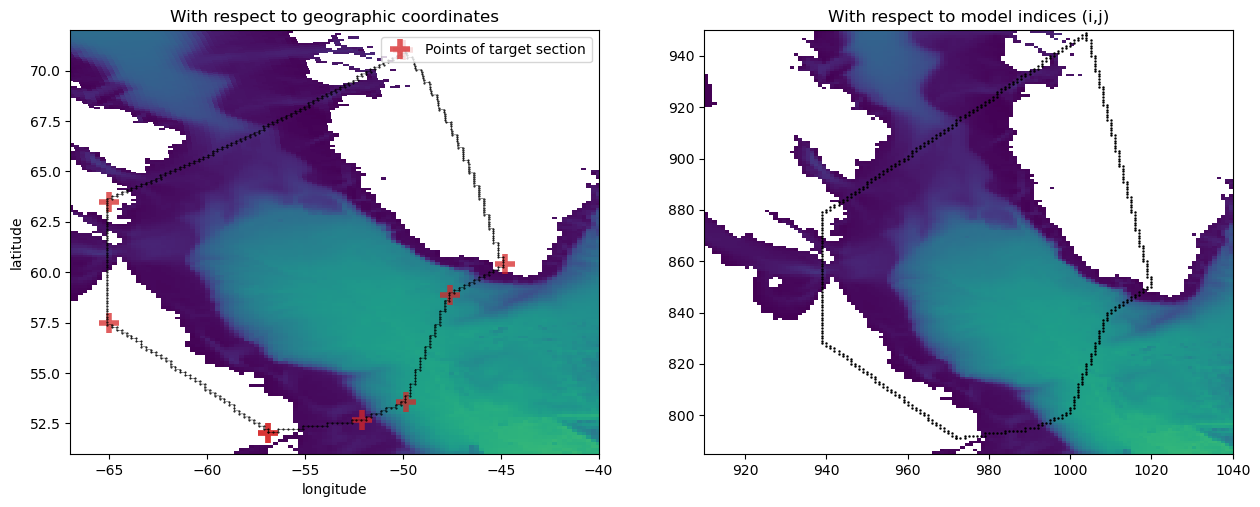

In [28]:
depth_masked = ds['deptho'].where(ds['deptho'] != 0)

plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(ds['geolon_c'], ds['geolat_c'], depth_masked)
plt.plot(Labrador_section_lons, Labrador_section_lats, "C3+", markersize=15., mew=4., alpha=0.75, label="Points of target section")
plt.plot(x, y, 'k.-', markersize=1., lw=0.3)
plt.axis([-67,-40, 51, 72])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(depth_masked)
plt.plot(i, j, 'k.', markersize=1.5, lw=0.5)
plt.axis([910, 1040, 785, 950])
plt.title("With respect to model indices (i,j)")
plt.show()

### Plot the hydrography and cell-integrated mass transport across the section

In [29]:
T = sectionate.extract_tracer('thetao', grid, i, j)

In [30]:
Trp = sectionate.convergent_transport(grid, i, j, counterclockwise=True)

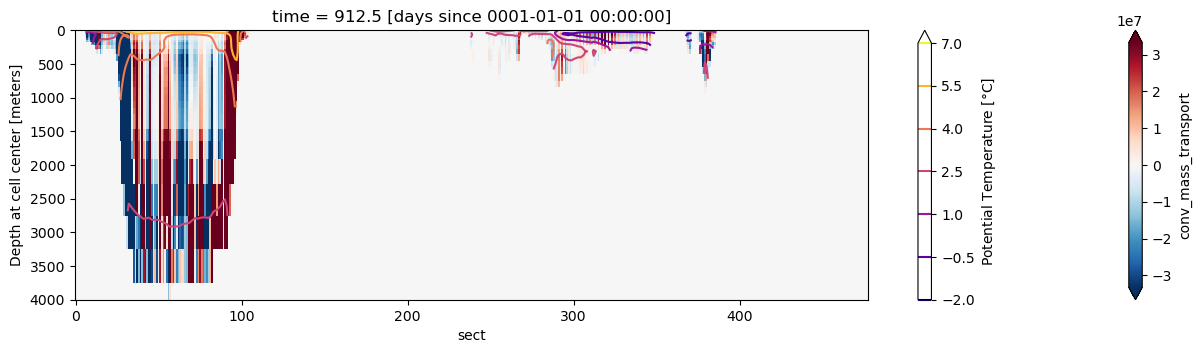

In [31]:
plt.figure(figsize=(16, 3.5))
Trp.isel(time=0)['conv_mass_transport'].plot(cmap='RdBu_r', yincrease=False, ylim=[4000,0], robust=True)
cs = T.isel(time=0).plot.contour(vmin=-2, vmax=7, cmap='plasma', yincrease=False, ylim=[4000,0])
plt.colorbar(cs, label=r"Potential Temperature [$\degree$C]")

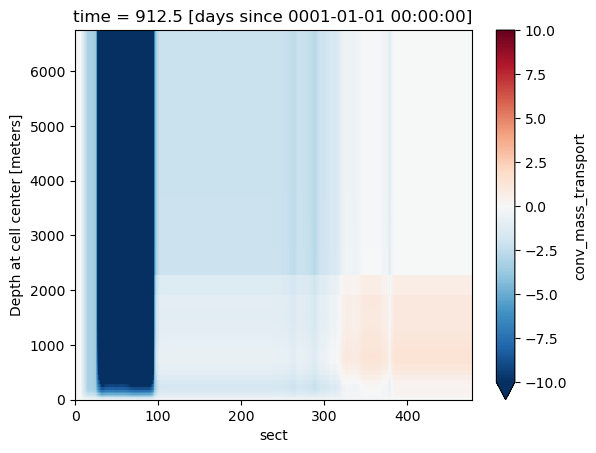

In [32]:
rho0 = 1035.
(Trp['conv_mass_transport'].isel(time=0).cumsum("sect").cumsum("z_l") / rho0*1e-6).plot(cmap="RdBu_r", vmin=-10, vmax=10)